In [35]:
import os, warnings, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
# warnings.filterwarnings("ignore")

# ML package
try:
    import xgboost as xgb
except Exception as e:
    raise RuntimeError("xgboost is required for this notebook.") from e

# Modeling / Portfolio
TRAIN_TEST_SPLIT_RATIO = 0.7
PORTFOLIO_PERCENTILE = 10   # long top p%, short bottom p%
REBALANCE_DAYS = 5          # ⬅ change to 5/10/20, etc.
STARTING_CAPITAL = 100_000

# RSRS (quantile thresholds)
RSRS_WINDOW = 18
RSRS_ZSCORE_WINDOW = 600
RSRS_ENTER_Q = 0.70     # enter if RSRS z > 70th percentile
RSRS_EXIT_Q  = 0.30     # exit  if RSRS z < 30th percentile

# T‑Sharpe (timing on benchmark quality)
TSHARPE_LOOKBACK = 60
TSHARPE_ENTER = -0.1
TSHARPE_EXIT  = -0.1

# Trading costs
FEE_PER_SIDE_TOTAL = 0.0002


## Load and pre-process data

In [ ]:
# Helper functions

def normalize_keys(df: pd.DataFrame, date_col: str, ticker_col: str) -> pd.DataFrame:
    """Standardize date & ticker columns for safe merging."""
    df = df.copy()
    df[date_col] = df[date_col].astype(str).str.replace(r"[^0-9]", "", regex=True).str.slice(0,8).str.zfill(8)
    df[ticker_col] = df[ticker_col].astype(str).str.strip()
    return df

def parse_date(series: pd.Series) -> pd.Series:
    """Parse date from YYYYMMDD (or fallback to best-effort)."""
    try:
        return pd.to_datetime(series, format="%Y%m%d", errors="raise")
    except Exception:
        return pd.to_datetime(series, errors="coerce")

def summarize_strategies(returns_dict, risk_free_rate=0.0, periods_per_year=252):
    """Summarize performance metrics for multiple return series."""
    rows = []
    for name, rets in returns_dict.items():
        if rets is None or len(rets)==0:
            continue
        rets = rets.dropna()
        if len(rets)==0: continue
        
        # cumulative growth
        cum = (1+rets).cumprod()
        
        # metrics
        ann_ret = (cum.iloc[-1]**(periods_per_year/len(rets)) - 1) * 100
        vol = rets.std() * np.sqrt(periods_per_year) * 100
        sharpe = (ann_ret - risk_free_rate) / vol if vol>0 else np.nan
        running_max = cum.cummax()
        dd = (cum/running_max - 1).min() *100
        
        rows.append({
            "Strategy": name,
            "Annual Return %": ann_ret,
            "Volatility %": vol,
            "Sharpe": sharpe,
            "Max Drawdown %": dd
        })
    
    return pd.DataFrame(rows).set_index("Strategy").sort_values("Sharpe", ascending=False)

REBAL = max(1, int(REBALANCE_DAYS))

# Read data
# df_f = pd.read_parquet("sp500_all_factors.parquet")
df_f = pd.read_csv("sp500_all_factors.csv").set_index(['DATE','ID'])
df_b = pd.read_csv("spx_index.csv").set_index(['DATE'])
# Normalize keys
DATE_COL = "DATE"
TICKER_COL = "ID"

# Factor columns
factor_cols = ['EPS','PB','PE','PS','ROE','ROA','OM','TOratio', 'FFratio', 
               'AssetTO', 'Rating', #'DE', 'DIVyield', 'D_EBITDA', 'GM','FCFyield', 
               'BID_ASK_SPR', 'VWAP_TOratio', 'VWAP_BID_VOL', 'VWAP_ASK_VOL', #'DailyRet','Price_Impact', 'MV',
       'Momentum_12_1', 'Reversal_1M', 'MACross', 'RSI14', 'MACD', 'MACD_diff',
       'VOL20', 'VOL60', 'Upp_Shad', 'Low_Shad', 'Body', 'BS_Pressure',
       'Volume_Spread', 'Liquid_Strength', 'Beta252', 'Target_yield']


# Benchmark
df_b = df_b.rename(columns={df_b.columns[-1]:"Close"})
#Benchmark daily returns
bm_daily_ret = df_b["Close"].pct_change().fillna(0.0)
bm_daily_ret.index = pd.to_datetime(bm_daily_ret.index)
print("Benchmark span:", bm_daily_ret.index.min(), "→", bm_daily_ret.index.max())


# Target: will stock outperform cross-sectional median return over next REBALANCE_DAYS?
df = df_f.copy()
df["future_ret"] = df.groupby(level="ID")["Close"].shift(-REBAL) / df["Close"] - 1
median_cs = df.groupby(level="DATE")["future_ret"].transform("median")
df["Target"] = (df["future_ret"] > median_cs).astype(int)

# Target: will stock forward return be in the top quantile?
def label_by_percentile(x, low=0.4, high=0.7):
    low_cut, high_cut = x.quantile([low, high])
    return np.where(x > high_cut, 1, 0) #np.where(x < low_cut, 0, np.nan)
# df['Target'] = df.groupby(level='DATE')['future_ret'].transform(label_by_percentile)


# Keep rows where features + target + price are present
required = factor_cols + ["Target","Close"]
clean = df.dropna(subset=required)

# Split by date (avoid leakage)
unique_dates = pd.Index(sorted(clean.index.get_level_values("DATE").unique()))
split_idx = max(1, min(int(len(unique_dates)*TRAIN_TEST_SPLIT_RATIO), len(unique_dates)-1))
split_date = unique_dates[split_idx]

train = clean[clean.index.get_level_values("DATE") < split_date]
test  = clean[clean.index.get_level_values("DATE") >= split_date]

print("Train period:", train.index.get_level_values("DATE").min(), "→", train.index.get_level_values("DATE").max())
print("Test  period:",  test.index.get_level_values("DATE").min(),  "→", test.index.get_level_values("DATE").max())

X_train, y_train = train[factor_cols], train["Target"]



Benchmark span: 2019-12-23 00:00:00 → 2025-09-22 00:00:00
Train period: 2021-01-25 → 2024-04-25
Test  period: 2024-04-26 → 2025-09-22


## Train XGBoost & Inspect Feature Importances

In [37]:

vi = int(len(sorted(X_train.index.get_level_values("DATE").unique()))*0.85)
tr_val_split_date = sorted(X_train.index.get_level_values("DATE").unique())[vi]
X_tr = X_train[X_train.index.get_level_values("DATE") < tr_val_split_date]
y_tr = y_train[y_train.index.get_level_values("DATE") < tr_val_split_date]
X_val = X_train[X_train.index.get_level_values("DATE") > tr_val_split_date]
y_val = y_train[y_train.index.get_level_values("DATE") > tr_val_split_date]

'''XGBoost model '''
xgb_model_rebal1 = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
)

fitted = False
try:
    xgb_model_rebal1.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False); fitted=True
except TypeError:
    try:
        es = xgb.callback.EarlyStopping(rounds=50, save_best=True)
        xgb_model_rebal1.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[es], verbose=False); fitted=True
    except TypeError:
        pass
if not fitted:
    xgb_model_rebal1.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)


In [38]:
model = xgb_model_rebal1
# Show & plot importances
fi = pd.DataFrame({"Feature": factor_cols, "Importance": model.feature_importances_}) \
       .sort_values("Importance", ascending=False).reset_index(drop=True)
display(fi.head(10))

,Feature,Importance
0,VOL60,0.04
1,VOL20,0.04
2,MACross,0.04
3,Momentum_12_1,0.04
4,Reversal_1M,0.04
5,Beta252,0.04
6,PE,0.04
7,EPS,0.04
8,Rating,0.04
9,FFratio,0.04


## Build Selection-only Long-Short strategy

In [39]:
REBAL = 1
PORTFOLIO_PERCENTILE = 5
FEE_PER_SIDE_TOTAL = 0.0002
model = xgb_model_rebal1

def make_rebalance_fee_series(
    ret_index: pd.DatetimeIndex,
    n_days: int,                   
    fee_per_side_total: float,         # e.g. 5 bps per side per rebalance
    turnover_rate = 1.0,         # 1.0=assume full refresh each side; 0.3=30% refresh
) -> pd.Series:
    """
    Returns a Series aligned to ret_index with zeros most days and a fee on rebalance days.
    Fee applied = turnover_rate * fee_per_side_total   (for the whole L/S book).
    """
    idx = pd.DatetimeIndex(ret_index).sort_values()
    fee = pd.Series(0.0, index=idx)

    # --- Build a boolean mask for rebalance days ---
    # Rebalance on the first day and then every n_days (in trading days)
    rb_mask = np.zeros(len(idx), dtype=bool)
    rb_mask[0] = True
    rb_mask[::n_days] = True

    # --- Fee applied on each rebalance day ---
    per_rebalance_fee = turnover_rate * fee_per_side_total * 2
    fee.values[rb_mask] = per_rebalance_fee
    return fee

def softmax_temp(x, T):
    x = np.asarray(x)
    z = (x - x.mean()) / (x.std(ddof=0) + 1e-12)  # stabilize
    e = np.exp(z / T)
    return e / e.sum()


X_test = test[factor_cols]
# model-estimated probability that the stock will rise
proba = model.predict_proba(X_test)[:,1]
# model-estimated probability that the stock will go down
proba2 = model.predict_proba(X_test)[:,0]
pred = X_test.copy()
pred["prob"] = proba
pred["prob2"] = proba2

close_panel = test["Close"].unstack(level="ID")
test_dates = sorted(pred.index.get_level_values("DATE").unique())
 
all_rets = pd.Series(index=pd.Index(test_dates, name='DATE'),dtype='float64')   # store daily L/S returns
baskets_by_date = {}   # store long/short baskets to compute turnover-based fees later

# long top k%, short bottom k%.
for i in range(0, max(0, len(test_dates)-1), REBAL):
    individual_stock_trades = []

# long top k%, short bottom k%.
for i in range(0, max(0, len(test_dates)-1), REBAL):
    d0 = test_dates[i]                               # start of current rebalance period
    d1 = test_dates[min(i+REBAL, len(test_dates)-1)] # start of current rebalance period; next rebalance date
    row = pred.loc[d0]

    # Skips if fewer than 2 stocks available (can’t form long/short)
    if row.shape[0] < 2: continue
    
    # Sort stocks by prob
    sorted_row = row.sort_values("prob", ascending=False)
    n = len(sorted_row)
    k = max(1, int(n * PORTFOLIO_PERCENTILE/100.0))
    sorted_row_short = row.sort_values("prob2", ascending=False)
    
  
    # List of long and short stock tickers
    long_tks  = sorted_row.head(k).index.tolist()
    short_tks = sorted_row.tail(k).index.tolist()
    #baskets_by_date[d0] = {"long": set(long_tks), "short": set(short_tks)}
    cols = list(set(long_tks).union(set(short_tks)))

    price_slice = close_panel.loc[d0:d1, cols]
    stock_rets = price_slice.pct_change().iloc[1:]
    if stock_rets.empty: continue
    
      
    # if weighted mean return and their probabilities weights
#     long_probs = sorted_row.head(k)["prob"].values
#     short_probs = sorted_row_short.head(k)["prob2"].values
#     long_weights = long_probs / long_probs.sum()
#     short_weights = short_probs / short_probs.sum()
#     long_weights = softmax_temp(long_probs, T=8.0)
#     short_weights = softmax_temp(short_probs, T=8.0)
#     long_ret = stock_rets[long_tks].mul(long_weights, axis=1).sum(axis=1).fillna(0)
#     short_ret = stock_rets[short_tks].mul(short_weights, axis=1).sum(axis=1).fillna(0)

    per_rebalance_fee = FEE_PER_SIDE_TOTAL * 2

    # 2. Get the number of stocks in our long portfolio
    num_stocks_held = len(long_tks)

    # 3. Allocate the total fee evenly across all stocks held
    fee_per_stock_held = per_rebalance_fee / num_stocks_held if num_stocks_held > 0 else 0

    # --- Log Performance for Each Stock ---
    # Calculate the gross cumulative return for each selected stock over this period
    period_gross_return = (1 + stock_rets[long_tks]).prod() - 1

    # Store each stock's ticker and its gross return, allocated fee, and net return
    for ticker, gross_ret in period_gross_return.items():
        individual_stock_trades.append({
            'Ticker': ticker,
            'Gross_Return': gross_ret,
            'Allocated_Fee': fee_per_stock_held,
            'Net_Return': gross_ret - fee_per_stock_held # Calculate the net return
        })

    # mean return
    long_ret  = stock_rets[long_tks].mean(axis=1).fillna(0)  # if NaN, fill 0
    short_ret = stock_rets[short_tks].mean(axis=1).fillna(0) # if NaN, fill 0
    
    
    # ls = (long_ret - short_ret) / 2.0   # long-short
    ls = long_ret                        # long only
    all_rets.loc[test_dates[i+1]:d1] = ls
    #print(long_tks)
    #print(d0)

# # Compute fees
# first_date = sorted(baskets_by_date.keys())[0]
# k_per_side = len(baskets_by_date[first_date]["long"])
# sel_fee_series = compute_selection_fees_turnover(
#     baskets_by_date=baskets_by_date,
#     sel_rets_index=all_rets.index,
#     k_per_side=k_per_side,
#     fee_per_side_total=FEE_PER_SIDE_TOTAL
# )

fee_series = make_rebalance_fee_series(
    ret_index=all_rets.index,
    n_days=REBAL,              # rebalance period
    fee_per_side_total=FEE_PER_SIDE_TOTAL, # e.g. 5 bps per side per rebalance
    turnover_rate=1.0          # e.g., estimate 30% of each side changes per rebalance
)

all_rets.index = pd.to_datetime(all_rets.index)
bench_ret = bm_daily_ret.loc[all_rets.index]
bench_cum = (1 + bench_ret).cumprod()

'''Useful for plotting'''
all_ret = all_rets
all_cum = (1 + all_rets).cumprod()
net_ret = all_rets - fee_series
net_cum = (1 + all_rets - fee_series).cumprod()

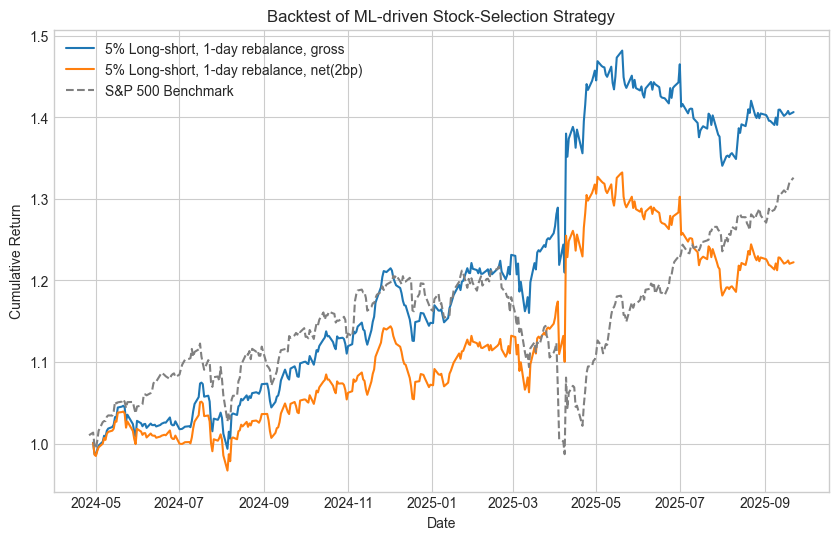

,Annual Return %,Volatility %,Sharpe,Max Drawdown %
Strategy,,,,
"5% Long-short, 1-day rebalance, gross",27.74,19.27,1.44,-9.53
SPX benchmark,22.38,17.45,1.28,-18.90
"5% Long-short, 1-day rebalance, net(2bp)",15.50,19.27,0.80,-11.33


In [40]:
plt.figure(figsize=(10,6))
# plt.plot(all_cum, label='5% Long-only, 1-day rebalance, gross')
# plt.plot(net_cum, label='5% Long-only, 1-day rebalance, net(2bp)')
plt.plot(all_cum, label='5% Long-short, 1-day rebalance, gross')
plt.plot(net_cum, label='5% Long-short, 1-day rebalance, net(2bp)')
plt.plot(bench_cum, label='S&P 500 Benchmark', linestyle='--', color='gray')
plt.title('Backtest of ML-driven Stock-Selection Strategy')
plt.xlabel('Date');plt.ylabel('Cumulative Return');plt.legend();plt.show()
summary = summarize_strategies({
    # "5% long-only, 1-day rebalance, gross": net_ret1,
    # "5% Long-only, 1-day rebalance, net(2bp)": net_ret2,
    "5% Long-short, 1-day rebalance, gross": all_ret,
    "5% Long-short, 1-day rebalance, net(2bp)": net_ret,
    "SPX benchmark": bench_ret,
})
pd.options.display.float_format = "{:.2f}".format; display(summary)

## Timing

In [41]:

def rolling_sharpe(ret: pd.Series, lookback=60):
    '''Computes a rolling Sharpe ratio for series ret'''
    def _sh(x):
        x = np.asarray(x); sd = x.std(ddof=0)
        if sd == 0: return np.nan
        return x.mean()/sd
    return ret.rolling(lookback).apply(_sh, raw=True)

def tsharpe_signal(ret: pd.Series, lookback=60, enter=0.2, exit=-0.1, plot=True):
    '''Converts the rolling Sharpe series (rs) into a binary trading signal (sig) using threshold-crossing rules'''
    rs = rolling_sharpe(ret, lookback).fillna(0.0)
    sig = pd.Series(0, index=rs.index, dtype=int)
    state = 0
    for dt, v in rs.items():
        if state==0 and v > enter: state = 1
        elif state==1 and v < exit: state = 0
        sig.loc[dt] = state

    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(rs.index, rs.values, label=f"Rolling Sharpe ({lookback}d)")
        plt.axhline(y=enter, linestyle="--", label=f"Enter {enter}")
        plt.axhline(y=exit, linestyle="--", label=f"Exit {exit}")
        plt.title("Rolling Sharpe Ratio (T-Sharpe Timing)")
        plt.xlabel("Date"); plt.ylabel("Sharpe"); plt.legend(); plt.grid(True); plt.show()
        summary = {"mean": float(rs.mean()), "std": float(rs.std()), "min": float(rs.min()),
                   "25%": float(rs.quantile(0.25)), "50%": float(rs.quantile(0.5)),
                   "75%": float(rs.quantile(0.75)), "max": float(rs.max())}
        print("Rolling Sharpe Summary:", summary)

    return sig, rs


def make_fee_with_timing(
    ret_index: pd.DatetimeIndex,
    sig: pd.Series,
    rebal_period: int,                # rebalance period (in trading days)
    fee_per_side_total: float,    # 5 bps per trade side
    turnover_rate = 1.0,            # fraction of portfolio replaced each rebalance
) -> pd.Series:
    """Create a fee series that: Charges fee on rebalance days only when the timing signal changes state"""
    idx = pd.DatetimeIndex(ret_index)
    sig = sig.reindex(idx).ffill().fillna(0).astype(int)
    fee = pd.Series(0.0, index=idx)

    # --- Identify rebalance days ---
    rebalance_mask = np.zeros(len(idx), dtype=bool)
    rebalance_mask[::rebal_period] = True

    # --- Identify signal change days (0→1 or 1→0) ---
    sig_change_mask = sig.ne(sig.shift(1))  # True where signal flips

    # --- Days when we actually trade ---
    trade_mask = rebalance_mask | sig_change_mask.values

    # --- Fee per rebalance event ---
    total_fee = turnover_rate * fee_per_side_total * 2

    # --- Assign fees ---
    fee.values[trade_mask] = total_fee
    
    return fee


In [42]:
ret = all_ret
TSHARPE_ENTER = -0.035
TSHARPE_EXIT = -0.035

# T-Sharpe timing signal, T-Sharpe rolling
tsh_sig_full, tsh_rs = tsharpe_signal(bm_daily_ret, TSHARPE_LOOKBACK, TSHARPE_ENTER, TSHARPE_EXIT, plot=False)
tsh_sig = tsh_sig_full.reindex(ret.index).ffill().fillna(0).astype(int)

fee_series = make_fee_with_timing(
    ret_index = ret.index,
    sig = tsh_sig,
    rebal_period = REBAL, 
    fee_per_side_total = FEE_PER_SIDE_TOTAL,
    turnover_rate = 1.0,  # full turnover
)

timed_ret = ret * tsh_sig
timed_cum = (1 + timed_ret).cumprod()
net_timed_ret = timed_ret - fee_series*tsh_sig
net_timed_cum = (1 + net_timed_ret).cumprod()

# plt.figure(figsize=(10,6))
# plt.plot(net_cum8, label='5% Long-only, 1-day, net(2bp)')
# plt.plot(net_cum7, label='5% Long-only, 5-day, net(2bp)')
# plt.plot(bench_cum, label='S&P 500 Benchmark', linestyle='--', color='gray')
# plt.title('Backtest of ML-driven Stock-Selection Strategy')
# plt.xlabel('Date'); plt.ylabel('Cumulative Return'); plt.legend(); plt.show()

# summary = summarize_strategies({
#     "5% long-short,1-day,net(2bp)": net_ret8,
#     "5% long-short,5-day,net(2bp)": net_ret7,
#     "SPX benchmark": bench_ret,
# })
# pd.options.display.float_format = "{:.2f}".format; display(summary)

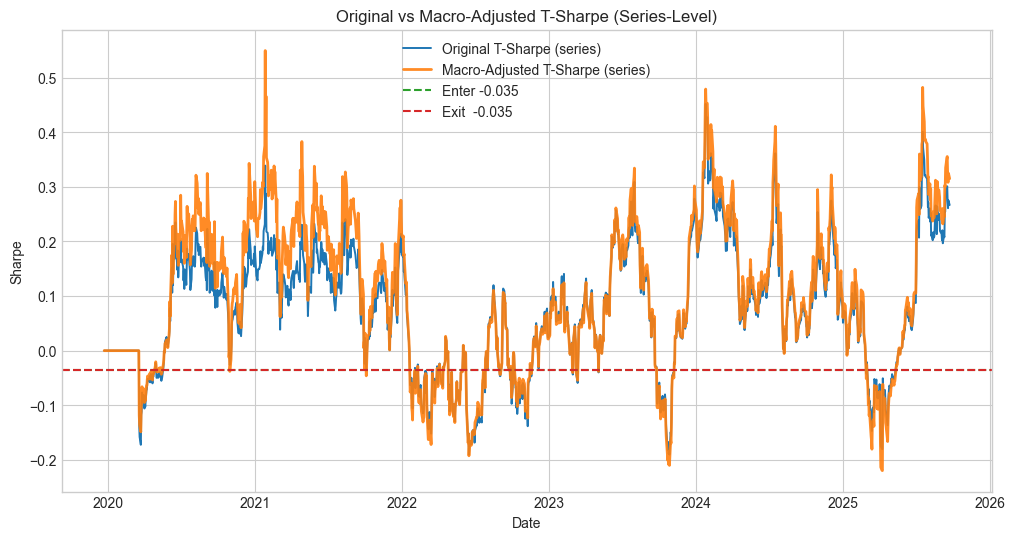

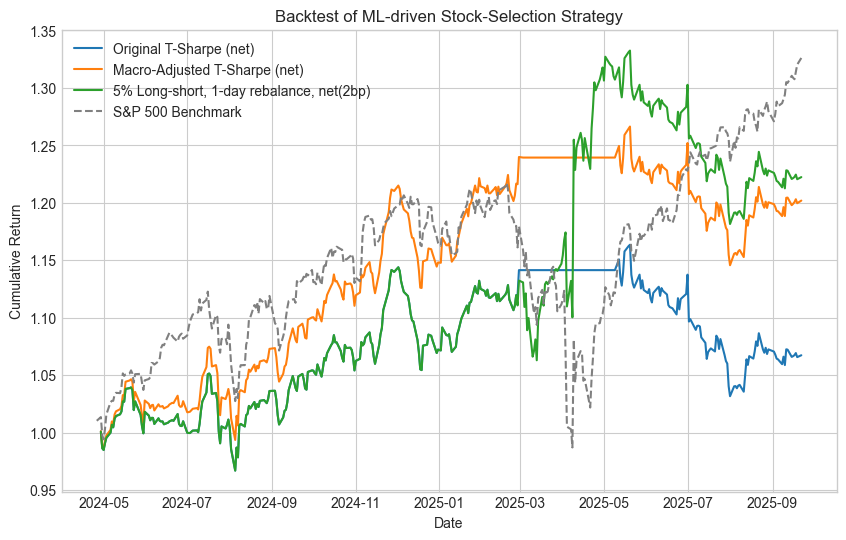

,Annual Return %,Volatility %,Sharpe,Max Drawdown %
Strategy,,,,
SPX benchmark,22.38,17.45,1.28,-18.90
Macro-Adjusted T-Sharpe (net),14.11,11.81,1.19,-9.53
Selection Only (net),15.50,19.27,0.80,-11.33
Original T-Sharpe (net),4.78,11.81,0.40,-11.33


In [43]:
# === New Cell: Macro-Adjusted T-Sharpe using PMI, CPI, and M1 (no overwrite) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------
# 0) Robust path handling for your macro file
#    (tries your Windows paths first, then /mnt/data fallback)
# ------------------------------------------------------------

# ------------------------------------------------------------
# 1) Load monthly macro data and coerce to numeric
# ------------------------------------------------------------
macro_m = pd.read_excel("macroeconomics_US.xlsx", index_col=0)
macro_m.index = pd.to_datetime(macro_m.index, errors="coerce")
macro_m = macro_m[macro_m.index.notna()]

# Coerce all to numeric (handles %, commas)
for c in macro_m.columns:
    macro_m[c] = pd.to_numeric(
        macro_m[c].astype(str).str.replace("%","").str.replace(",",""),
        errors="coerce"
    )

# Keep only expected columns
expected_cols = ["PMI", "CPI", "M1"]
missing = [c for c in expected_cols if c not in macro_m.columns]
if missing:
    raise KeyError(f"Missing required macro columns in {macro_path.name}: {missing}. "
                   f"Found columns: {list(macro_m.columns)}")

macro_m = macro_m[expected_cols].copy()

# ------------------------------------------------------------
# 2) Z-score standardization (monthly)
# ------------------------------------------------------------
macro_std_m = (macro_m - macro_m.mean()) / macro_m.std()

# Composite macro score:
#   + M1 (liquidity)    -> boost exposure
#   + PMI (momentum)    -> boost exposure
#   - CPI (inflation)   -> reduce exposure
macro_std_m["macro_score"] = (
    0.4 * macro_std_m["M1"]
  - 0.3 * macro_std_m["CPI"]
  + 0.3 * macro_std_m["PMI"]
)

# ------------------------------------------------------------
# 3) Align monthly → daily → T-Sharpe index
#     Your notebook defines: tsh_rs (rolling Sharpe series)
# ------------------------------------------------------------

# Resample monthly to daily by forward-fill, then align to tsh_rs index
macro_daily = macro_std_m.resample("D").ffill()
macro_on_tsh = macro_daily.reindex(tsh_rs.index).ffill()
macro_on_tsh["macro_score"] = macro_on_tsh["macro_score"].fillna(0.0)

# ------------------------------------------------------------
# 4) Build macro-adjusted T-Sharpe series and timing signal
#     Use your existing thresholds: TSHARPE_ENTER / TSHARPE_EXIT
# ------------------------------------------------------------
alpha = 0.5  # sensitivity factor; tune 0.3–0.8 if you like
tsh_rs_adj = tsh_rs * (1 + alpha * macro_on_tsh["macro_score"])

def tsharpe_signal_from_series(rs_series: pd.Series, enter: float, exit: float) -> pd.Series:
    """State machine on a precomputed Sharpe series to get a 0/1 timing signal."""
    sig = pd.Series(0, index=rs_series.index, dtype=int)
    state = 0
    for dt, v in rs_series.items():
        if state == 0 and v > enter:
            state = 1
        elif state == 1 and v < exit:
            state = 0
        sig.loc[dt] = state
    return sig

# Use your configured thresholds
tsh_sig_adj_full = tsharpe_signal_from_series(
    tsh_rs_adj, enter=TSHARPE_ENTER, exit=TSHARPE_EXIT
)

# Align adjusted timing to selection return index
tsh_sig_adj = tsh_sig_adj_full.reindex(all_rets.index).ffill().fillna(0).astype(int)

# ------------------------------------------------------------
# 5) Plots: original vs adjusted T-Sharpe series
# ------------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(tsh_rs.index, tsh_rs.values,  label="Original T-Sharpe (series)", linewidth=1.4)
plt.plot(tsh_rs_adj.index, tsh_rs_adj.values, label="Macro-Adjusted T-Sharpe (series)", linewidth=2.0, alpha=0.9)
plt.axhline(TSHARPE_ENTER, linestyle="--", color="tab:green",  label=f"Enter {TSHARPE_ENTER}")
plt.axhline(TSHARPE_EXIT,  linestyle="--", color="tab:red",    label=f"Exit  {TSHARPE_EXIT}")
plt.title("Original vs Macro-Adjusted T-Sharpe (Series-Level)")
plt.xlabel("Date"); plt.ylabel("Sharpe"); plt.grid(True); plt.legend()
plt.show()

# ------------------------------------------------------------
# 6) Strategy returns using adjusted timing (gross & net)
#     Mirrors your existing timing-cost model:
#       sel_tsh_gross  = sel_rets * tsh_sig
#       sel_tsh_net    = sel_tsh_gross - (flips * fee_per_flip)
# ------------------------------------------------------------
# Gross (adjusted)
sel_tsh_gross_adj = all_rets * tsh_sig_adj

# Timing flip costs (use your existing fee model)
fee_per_flip = 2.0 * FEE_PER_SIDE_TOTAL
tsh_flip_adj = tsh_sig_adj.diff().abs().fillna(0.0)

sel_tsh_net_adj = sel_tsh_gross_adj - tsh_flip_adj * fee_per_flip

marco_timed_ret = ret * tsh_sig_adj
marco_timed_cum = (1 + marco_timed_ret).cumprod()
net_marco_timed_ret = sel_tsh_net_adj
net_marco_timed_cum = (1 + net_marco_timed_ret).cumprod()

# ------------------------------------------------------------
# 7) Equity curve comparison (original vs adjusted)
#     We DO NOT overwrite your existing variables (sel_tsh_gross, sel_tsh_net, etc.)
# ------------------------------------------------------------
def plot_equity_curves(series_dict, title):
    fig, ax = plt.subplots(figsize=(12,7))
    for name, rets in series_dict.items():
        if rets is None or len(rets) == 0:
            continue
        eq = (1 + rets).cumprod() * STARTING_CAPITAL
        ax.plot(eq.index, eq.values, label=name)
    ax.set_title(title)
    ax.set_xlabel("Date"); ax.set_ylabel("Portfolio Value")
    ax.legend(); ax.grid(True)
    plt.show()

# plot_equity_curves({
#     "Original T-Sharpe (net)": sel_tsh_net,
#     "Macro-Adjusted T-Sharpe (net)": sel_tsh_net_adj,
#     "SP500 benchmark": bm_aligned
# }, title="Equity — T-Sharpe Timing: Original vs Macro-Adjusted (Net)")

# # (Optional) If you want to include selection-only and OR strategies for context:
# plot_equity_curves({
#     "Selection only (net)": selection_only_net_xgb,
#     "RSRS timing (net)": sel_rsrs_net,
#     "Original T-Sharpe (net)": sel_tsh_net,
#     "Macro-Adjusted T-Sharpe (net)": sel_tsh_net_adj,
#     "OR timing (net)": sel_or_net,
#     "SP500 benchmark": bm_aligned
# }, title="Equity — All Timing Variants (Net)")

plt.figure(figsize=(10,6))
# plt.plot(all_cum, label='5% Long-only, 1-day rebalance, gross')
# plt.plot(net_cum, label='5% Long-only, 1-day rebalance, net(2bp)')
plt.plot(net_timed_cum, label='Original T-Sharpe (net)')
plt.plot(net_marco_timed_cum, label='Macro-Adjusted T-Sharpe (net)')
plt.plot(net_cum, label='5% Long-short, 1-day rebalance, net(2bp)')
plt.plot(bench_cum, label='S&P 500 Benchmark', linestyle='--', color='gray')
plt.title('Backtest of ML-driven Stock-Selection Strategy')
plt.xlabel('Date');plt.ylabel('Cumulative Return');plt.legend();plt.show()
summary = summarize_strategies({
    # "5% long-only, 1-day rebalance, gross": net_ret1,
    # "5% Long-only, 1-day rebalance, net(2bp)": net_ret2,
    "Selection Only (net)": net_ret,
    "Original T-Sharpe (net)": net_timed_ret,
    "Macro-Adjusted T-Sharpe (net)": net_marco_timed_ret,
    "SPX benchmark": bench_ret,
})
pd.options.display.float_format = "{:.2f}".format; display(summary)


In [44]:
print("T-Sharpe mean value: ",tsh_rs.mean(), " std:", tsh_rs.std(), "reasonable thresholds range", tsh_rs.mean()+ tsh_rs.std(), tsh_rs.mean()-tsh_rs.std())
print("Macro adjusted T-Sharpe mean value: ",tsh_rs_adj.mean(), " std:", tsh_rs_adj.std(), "reasonable thresholds range", tsh_rs_adj.mean()+ tsh_rs_adj.std(), tsh_rs_adj.mean()- tsh_rs_adj.std())

T-Sharpe mean value:  0.07853114207961054  std: 0.11354982335803414 reasonable thresholds range 0.1920809654376447 -0.0350186812784236
Macro adjusted T-Sharpe mean value:  0.10071431747278059  std: 0.13617868132421804 reasonable thresholds range 0.23689299879699863 -0.03546436385143745


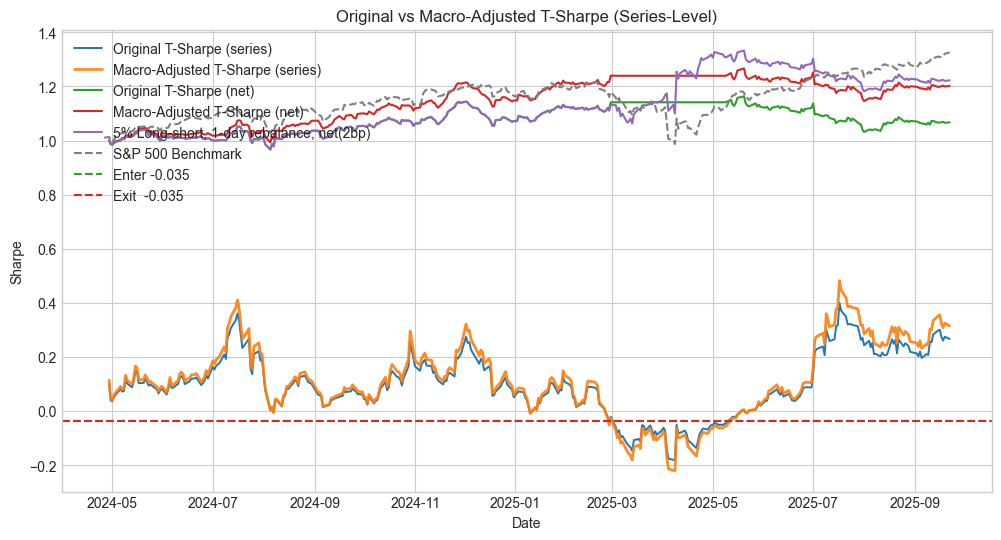

In [45]:
plt.figure(figsize=(12,6))
plt.plot(tsh_rs[tsh_rs.index > split_date].index, tsh_rs[tsh_rs.index > split_date].values,  label="Original T-Sharpe (series)", linewidth=1.4)
plt.plot(tsh_rs_adj[tsh_rs_adj.index > split_date].index, tsh_rs_adj[tsh_rs_adj.index > split_date].values, label="Macro-Adjusted T-Sharpe (series)", linewidth=2.0, alpha=0.9)
plt.plot(net_timed_cum, label='Original T-Sharpe (net)')
plt.plot(net_marco_timed_cum, label='Macro-Adjusted T-Sharpe (net)')
plt.plot(net_cum, label='5% Long-short, 1-day rebalance, net(2bp)')
plt.plot(bench_cum, label='S&P 500 Benchmark', linestyle='--', color='gray')
plt.axhline(TSHARPE_ENTER, linestyle="--", color="tab:green",  label=f"Enter {TSHARPE_ENTER}")
plt.axhline(TSHARPE_EXIT,  linestyle="--", color="tab:red",    label=f"Exit  {TSHARPE_EXIT}")
plt.title("Original vs Macro-Adjusted T-Sharpe (Series-Level)")
plt.xlabel("Date"); plt.ylabel("Sharpe"); plt.grid(True); plt.legend(loc = 'upper left')
plt.show()


In [46]:
# def plot_equity(series_dict, title="Equity Curves"):
#     fig, ax = plt.subplots(figsize=(12,7))
    
#     # Predefined colors by strategy group
#     color_map = {
#         "Selection": "tab:blue",
#         "RSRS": "tab:green",
#         "T-Sharpe": "tab:red",
#         "OR": "tab:purple",
#         "Partial": "tab:orange",
#         "Benchmark": "gray"
#     }
    
#     # Plot with style (gross=solid, net=dashed)
#     for name, rets in series_dict.items():
#         if rets is None or len(rets)==0: 
#             continue
#         eq = (1+rets).cumprod()*STARTING_CAPITAL
        
#         # choose color by keyword
#         c = None
#         for key in color_map:
#             if key in name:
#                 c = color_map[key]
#                 break
#         if c is None:
#             c = "gray"
        
#         # solid line for gross, dashed for net
#         style = "-" if "(gross)" in name else "--" if "(net)" in name else "-"
        
#         ax.plot(eq.index, eq.values, label=name, color=c, linestyle=style, linewidth=1.8)
    
#     ax.set_title(title)
#     ax.set_xlabel("Date")
#     ax.set_ylabel("Portfolio Value")
#     ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: f"${x:,.0f}"))
#     ax.legend(loc="upper left", bbox_to_anchor=(1,1))  # place legend outside plot
#     ax.grid(True)
#     plt.tight_layout()
#     plt.show()

# # plot_equity({
# #     "Selection only (gross)": selection_only_gross,
# #     "Selection only (net)": selection_only_net,
# #     "RSRS timing (gross)": sel_rsrs_gross,
# #     "RSRS timing (net)": sel_rsrs_net,
# #     "T-Sharpe timing (gross)": sel_tsh_gross,
# #     "T-Sharpe timing (net)": sel_tsh_net,
# #     "OR timing (gross)": sel_or_gross,
# #     "OR timing (net)": sel_or_net,
# #     "Partial timing (gross)": sel_with_partial_timing,
# #     "Partial timing (net)": sel_with_partial_timing_net,
# #     "SP500 Benchmark": bm_aligned
# # }, title="Equity Curves")

In [47]:
# FEE_PER_SIDE_TOTAL = 0.0002
# def compute_selection_fees_turnover(baskets_by_date, sel_rets_index, k_per_side, fee_per_side_total):
#     """Turnover and fee estimation for equal-weight L/S portfolios"""
#     fee = pd.Series(0.0, index=sel_rets_index)
#     prev_long, prev_short = set(), set()

#     for d0 in sorted(baskets_by_date.keys()):
#         current = baskets_by_date[d0]
#         long_tks, short_tks = current["long"], current["short"]
#         k = max(1, k_per_side)

#         entries_long = len(long_tks - prev_long); exits_long = len(prev_long - long_tks)
#         entries_short = len(short_tks - prev_short); exits_short = len(prev_short - short_tks)
#         gross_turnover = ((entries_long + exits_long) + (entries_short + exits_short)) / k
        

#         fee_decimal = gross_turnover * fee_per_side_total
        

#         # find first valid trading day >= d0
#         later_dates = sel_rets_index[sel_rets_index >= d0]
#         if len(later_dates) > 0:
#             fee.loc[later_dates[0]] += fee_decimal

#         prev_long, prev_short = long_tks, short_tks

#     return fee

# # 6) Strategy returns using adjusted timing (gross & net)
# #     Mirrors your existing timing-cost model:
# #       sel_tsh_gross  = sel_rets * tsh_sig
# #       sel_tsh_net    = sel_tsh_gross - (flips * fee_per_flip)
# # ------------------------------------------------------------
# # Gross (adjusted)
# sel_tsh_gross_adj = sel_rets_xgb * tsh_sig_adj

# # Timing flip costs (use your existing fee model)
# fee_per_flip = 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)
# tsh_flip_adj = tsh_sig_adj.diff().abs().fillna(0.0)

# sel_tsh_net_adj = sel_tsh_gross_adj - tsh_flip_adj * fee_per_flip

## Generate Alpha and Beta

In [48]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

=== CAPM Regression Results ===
                            OLS Regression Results                            
Dep. Variable:              rp_excess   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     376.6
Date:                 周二, 28 10月 2025   Prob (F-statistic):           5.16e-58
Time:                        20:15:07   Log-Likelihood:                 1224.7
No. Observations:                 364   AIC:                            -2445.
Df Residuals:                     362   BIC:                            -2438.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.000

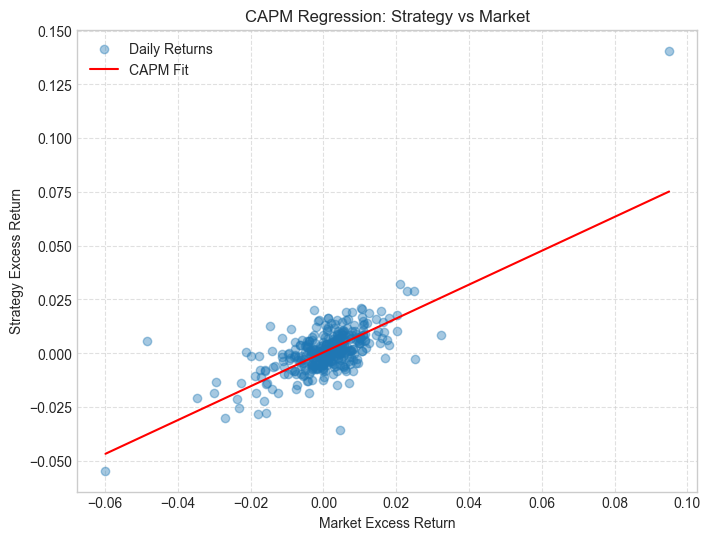

In [49]:
# === 1.1 Load 10Y Treasury (risk-free rate, annualized) ===
rf = pd.read_csv("10Y_US_Treasury.csv")
rf.columns = [c.lower() for c in rf.columns]

# expected columns like: ['date','yield'] or similar
rf.rename(columns={'risk free rate':'rf_annual'}, inplace=True)
rf['DATE'] = pd.to_datetime(rf['date'])
rf.set_index('DATE', inplace=True)

# Convert annualized yield (%) to decimal and then to daily rate
rf['rf_annual'] = rf['rf_annual'] / 100.0
rf['rf_daily'] = np.exp(rf['rf_annual'] / 252) - 1
rf = rf[rf.index >= split_date]

# === 1.2 Load S&P500 index (market benchmark) ===
spx = pd.read_csv("spx_index.csv")
spx.columns = [c.lower() for c in spx.columns]
spx.rename(columns={'spx index':'spx_close'}, inplace=True)
spx['DATE'] = pd.to_datetime(spx['date'])
spx.set_index('DATE', inplace=True)
spx = spx[spx.index >= split_date]

# Compute daily market returns
spx['rm'] = spx['spx_close'].pct_change()

#=== 2. Align returns and risk-free rate ===
strategy_returns = all_rets # your strategy returns series

# Combine into a single DataFrame
df = pd.concat([strategy_returns, spx['rm'], rf['rf_daily']], axis=1)
df.columns = ['rp', 'rm', 'rf']
df = df.ffill().dropna()

# -------------------------------
# 3. Compute excess returns
# -------------------------------
df['rp_excess'] = df['rp'] - df['rf']
df['rm_excess'] = df['rm'] - df['rf']

# -------------------------------
# 4. CAPM Regression
# -------------------------------
X = sm.add_constant(df['rm_excess'])
model = sm.OLS(df['rp_excess'], X).fit()
alpha_daily, beta = model.params

alpha_annual = alpha_daily * 252
print("=== CAPM Regression Results ===")
print(model.summary())
print(f"\nDaily Alpha: {alpha_daily:.6f}")
print(f"Annualized Alpha: {alpha_annual:.4%}")
print(f"Beta: {beta:.3f}")

# -------------------------------
# 5. Visualization (optional)
# -------------------------------
plt.figure(figsize=(8,6))
plt.scatter(df['rm_excess'], df['rp_excess'], alpha=0.4, label='Daily Returns')
x_vals = np.linspace(df['rm_excess'].min(), df['rm_excess'].max(), 100)
plt.plot(x_vals, alpha_daily + beta * x_vals, color='red', label='CAPM Fit')
plt.title('CAPM Regression: Strategy vs Market')
plt.xlabel('Market Excess Return')
plt.ylabel('Strategy Excess Return')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Single Factor test

--- Strategy Performance ---
Total Cumulative Return: 120.18%
Annualized Return: 16.31%


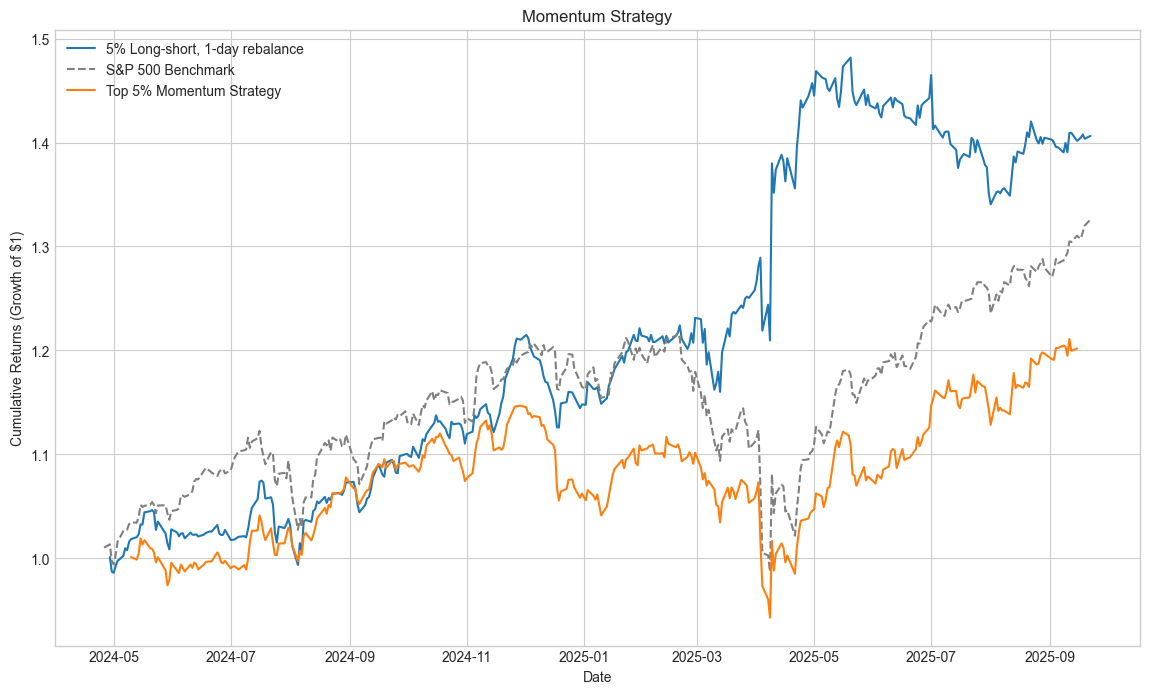

In [50]:
# df_single = pd.read_csv("sp500_all_factors.csv")
MOMENTUM_DAYS = 10
signal_name = f'roc_{MOMENTUM_DAYS}d'

clean_filtered = clean.loc[clean.index.get_level_values('DATE') >= split_date]

df_single = clean_filtered.sort_index(level=['DATE', 'ID'])


df_single[signal_name] = df_single.groupby(level='ID')['Close'].pct_change(MOMENTUM_DAYS) * 100

df_single['future_return'] = df_single.groupby(level='ID')['Close'].pct_change(REBAL).shift(-REBAL)
df_single.dropna(inplace=True)
daily_returns = []
trade_dates = []

# Group by the 'Date' to iterate through each trading day
for date, daily_data in df_single.groupby(level='DATE'):
    # print(date, daily_data)
    # a. Rank stocks for this day based on our momentum signal
    ranked_data = daily_data.sort_values(by='OM', ascending=False)#can replace the signal_name with any other factor
    
    # b. Determine how many stocks to buy
    num_stocks_to_buy = int(len(ranked_data) * (PORTFOLIO_PERCENTILE / 100.0))
    
    # Skip this day if the portfolio would be empty
    if num_stocks_to_buy == 0:
        continue
        
    # c. Select the top N% of stocks (our "winners" portfolio)
    winners_portfolio = ranked_data.head(num_stocks_to_buy)
    
    # d. Calculate the portfolio's return for the NEXT day
    # This is the equal-weighted average of the future returns of our selected stocks.
    portfolio_return = winners_portfolio['future_return'].mean()
    
    # f. Store the results for this day
    daily_returns.append(portfolio_return)
    trade_dates.append(date)

# Create a results DataFrame from the daily returns
results_df = pd.DataFrame({
    'Strategy': daily_returns,
}, index=pd.Index(trade_dates, name='DATE'))

# Calculate cumulative returns (the growth of $1)
strategy_cumulative = (1 + results_df['Strategy']).cumprod()
# Ensure all time series indices are datetime
strategy_cumulative.index = pd.to_datetime(strategy_cumulative.index)

# Calculate annualized returns (assuming 252 trading days a year)
annualized_strategy_return = (1 + results_df['Strategy'].mean())**252 - 1

print("--- Strategy Performance ---")
print(f"Total Cumulative Return: {strategy_cumulative.iloc[-1]:.2%}")
print(f"Annualized Return: {annualized_strategy_return:.2%}")

# Plot the equity curves
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))
# strategy_cumulative.plot(label=f'Top {PORTFOLIO_PERCENTILE}% Momentum Strategy', legend=True, linewidth=2)
plt.plot(all_cum, label='5% Long-short, 1-day rebalance')
plt.plot(bench_cum, label='S&P 500 Benchmark', linestyle='--', color='gray')
plt.plot(strategy_cumulative, label=f'Top {PORTFOLIO_PERCENTILE}% Momentum Strategy')
plt.title('Momentum Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (Growth of $1)')
plt.legend()
plt.show()

In [51]:
# 1. Convert the list of trade records into a DataFrame
trades_df = pd.DataFrame(individual_stock_trades)

# 2. Aggregate the results for each stock
# We sum the returns and fees from all the times a stock was traded
stock_contribution = trades_df.groupby('Ticker')[['Gross_Return', 'Allocated_Fee', 'Net_Return']].sum()

# 3. Count how many times each stock was selected
trade_counts = trades_df.groupby('Ticker').size().rename('Times_Selected')

# 4. Combine into a final summary DataFrame and sort by net contribution
stock_summary_df = pd.concat([stock_contribution, trade_counts], axis=1)
stock_summary_df = stock_summary_df.sort_values(by='Net_Return', ascending=False)

# 5. Display the results
print("\n--- Analysis of Stocks Actually Traded by the Algorithm (Including Fees) ---")

print("\n--- Top 10 Stock Contributors to Portfolio Return (Net of Fees) ---")
print(stock_summary_df.head(10).to_string(formatters={
    'Gross_Return': '{:,.2%}'.format,
    'Allocated_Fee': '{:,.2%}'.format
    # 'Net_Return': '{:,.2%}'.format
}))

print("\n--- Bottom 10 Stock Contributors (Detractors) (Net of Fees) ---")
print(stock_summary_df.tail(10).to_string(formatters={
    'Gross_Return': '{:,.2%}'.format,
    'Allocated_Fee': '{:,.2%}'.format
    # 'Net_Return': '{:,.2%}'.format
}))


--- Analysis of Stocks Actually Traded by the Algorithm (Including Fees) ---

--- Top 10 Stock Contributors to Portfolio Return (Net of Fees) ---
               Gross_Return Allocated_Fee  Net_Return  Times_Selected
Ticker                                                               
HOOD UW Equity       86.93%         0.07%        0.87              37
SMCI UW Equity       70.69%         0.12%        0.71              68
NCLH UN Equity       63.24%         0.16%        0.63              88
CRL UN Equity        41.93%         0.04%        0.42              21
APA UW Equity        40.83%         0.08%        0.41              44
MPWR UW Equity       38.02%         0.03%        0.38              16
GPN UN Equity        37.90%         0.05%        0.38              28
EL UN Equity         32.17%         0.07%        0.32              37
VST UN Equity        31.23%         0.09%        0.31              50
XYZ UN Equity        29.03%         0.08%        0.29              45

--- Bottom 1

In [ ]:
# oneday_gross = all_cum
# fiveday_gross = all_cum